In [1]:
import os
import pandas as pd
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import sys
import os
from matplotlib.image import imread
from PIL import Image
import random

In [5]:

file_name = path+'train_0.tfrecord'
tf.compat.v1.enable_eager_execution()
sum(1 for _ in tf.data.TFRecordDataset(file_name))

1024

In [ ]:
file_name = path+'train_'+str(file_index)+'.tfrecord'
tf.compat.v1.enable_eager_execution()
sum(1 for _ in tf.data.TFRecordDataset(file_name))

In [3]:
file_name = 'PLANTCLEF2015/tfrecords/sandbox/train_499.tfrecord'
tf.compat.v1.enable_eager_execution()
sum(1 for _ in tf.data.TFRecordDataset(file_name))

832

In [2]:
def preprocessing_model():
  input = tf.keras.Input(shape=(224, 224, 3), name="input")
  
  central_crop = tf.keras.layers.experimental.preprocessing.CenterCrop(height=112,width=112)(input) 
  resized_single_crop = tf.keras.layers.experimental.preprocessing.Resizing(224,224)(central_crop)

  central_crop2 = tf.keras.layers.experimental.preprocessing.CenterCrop(height=56,width=56)(input)
  resized_single_crop2 = tf.keras.layers.experimental.preprocessing.Resizing(224,224)(central_crop2)
  
  random_crop = tf.keras.Sequential([tf.keras.layers.experimental.preprocessing.RandomCrop(height=56,width=74)])

  random_crop0 = random_crop(input,training=True)
  random_crop1 = random_crop(input,training=True)
  random_crop2 = random_crop(input,training=True)
  random_crop3 = random_crop(input,training=True)
  random_crop4 = random_crop(input,training=True) 
  random_crop5 = random_crop(input,training=True) 

  crops = tf.keras.layers.concatenate([random_crop0,random_crop1,random_crop2,random_crop3,random_crop4,random_crop5],axis=0)
  resized_crops = tf.keras.layers.experimental.preprocessing.Resizing(224,224)(crops)

  rotate_1 = tf.keras.Sequential([tf.keras.layers.experimental.preprocessing.RandomRotation(factor=[-0.125,0.125])])
  rotated_a = rotate_1(input,training=True)
  rotated_b = rotate_1(input,training=True)

  color_distortion = RandomColorDistortion()
  color_a = color_distortion(input, training=True)
  color_b = color_distortion(input, training=True)

  zoom = tf.keras.layers.RandomZoom(height_factor=[-0.7,0.7],width_factor=[-0.7,0.7])
  random_zoom = zoom(input, training=True)
  
  gaussian_noise = tf.keras.layers.GaussianNoise(stddev=25, seed=74)
  noisy_a = gaussian_noise(input,training=True)
  noisy_b = gaussian_noise(input,training=True)

  augmented_images = tf.keras.layers.concatenate([input,resized_crops, color_a,resized_single_crop,rotated_a, noisy_a,resized_single_crop2, color_b,rotated_b,random_zoom,noisy_b],axis=0)

  translate_1 = tf.keras.Sequential([tf.keras.layers.experimental.preprocessing.RandomTranslation(height_factor=(-0.25,0.25),width_factor=(-0.25,0.25))])
  translated_a = translate_1(augmented_images,training=True)

  augmented_images = tf.keras.layers.concatenate([augmented_images,translated_a],axis=0)
  mirrored_versions = tf.keras.Sequential([tf.keras.layers.experimental.preprocessing.RandomFlip('vertical')])
  mirrored_images = mirrored_versions(augmented_images,training=True)
  augmented_images = tf.keras.layers.concatenate([augmented_images,mirrored_images],axis=0)

  model = tf.keras.Model(inputs=input,outputs=augmented_images)
  return model

class RandomColorDistortion(tf.keras.layers.Layer):
    def __init__(self, contrast_range=[0.25, 1.5], 
                 brightness_delta=[-0.2, 0.2], **kwargs):
        super(RandomColorDistortion, self).__init__(**kwargs)
        self.contrast_range = contrast_range
        self.brightness_delta = brightness_delta
    
    def call(self, images, training=None):
        if not training:
            return images
        
        contrast = np.random.uniform(
            self.contrast_range[0], self.contrast_range[1])
        brightness = np.random.uniform(
            self.brightness_delta[0], self.brightness_delta[1])
        
        images = tf.image.adjust_contrast(images, contrast)
        images = tf.image.adjust_brightness(images, brightness)
        #images = tf.clip_by_value(images, 0, 1)
        return images

In [3]:
file_name = 'PLANTCLEF2015/tfrecords/train_0.tfrecord'
path = 'PLANTCLEF2015/tfrecords/sandbox/' 

data_augmentation = preprocessing_model()

batch_size = 16
tpu_arg_0 = 64 * batch_size

data_reshape = lambda x,y: (tf.reshape(x,shape=(tpu_arg_0,224,224,3)), (tf.reshape(y[0],shape=(tpu_arg_0,1000)), tf.reshape(y[1],shape=(tpu_arg_0,516)),tf.reshape(y[2],shape=(tpu_arg_0,124))))
augmentation_pipeline = lambda x,y: (data_augmentation(tf.expand_dims(x,axis=0)),(tf.tile(tf.reshape(y[0],[1,1000]),[64,1]),tf.tile(tf.reshape(y[1],[1,516]),[64,1]),tf.tile(tf.reshape(y[2],[1,124]),[64,1])))

AUTO = tf.data.AUTOTUNE
train_dataset = tf.data.TFRecordDataset(buffer_size=int(2e+8),num_parallel_reads=AUTO,filenames=file_name).map(parsing_fn,num_parallel_calls=AUTO)
train_dataset = train_dataset.map(augmentation_pipeline, num_parallel_calls=AUTO).batch(batch_size=batch_size, drop_remainder=False)
train_dataset = train_dataset.map(data_reshape,num_parallel_calls=AUTO)
train_dataset = train_dataset.prefetch(AUTO)
#train_dataset = train_dataset.repeat()



iterator = tf.compat.v1.data.make_one_shot_iterator(train_dataset) 

# Iterate the 8192 images tfrecord in batches of size 16.   
# Augment each batch to 16 * 64 = 1024
# after every 8 repetitions start appending to a new file 
file_index = 0
for i in range(1): # 512
  image, labels = iterator.get_next()
  if i % 8 == 0:    
    file_index = file_index + 1
  print('Converting to: ', path+'train_'+str(file_index)+'.tfrecord')  
  convert(image,labels,path+'train_'+str(file_index)+'.tfrecord')
  

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


NameError: name 'parsing_fn' is not defined

In [4]:
file_name = 'PLANTCLEF2015/tfrecords/train_0.tfrecord'
path = 'PLANTCLEF2015/tfrecords/sandbox/' 

data_augmentation = preprocessing_model()

batch_size = 16
tpu_arg_0 = 64 * batch_size

data_reshape = lambda x,y: (tf.reshape(x,shape=(tpu_arg_0,224,224,3)), (tf.reshape(y[0],shape=(tpu_arg_0,1000)), tf.reshape(y[1],shape=(tpu_arg_0,516)),tf.reshape(y[2],shape=(tpu_arg_0,124))))
augmentation_pipeline = lambda x,y: (data_augmentation(tf.expand_dims(x,axis=0)),(tf.tile(tf.reshape(y[0],[1,1000]),[64,1]),tf.tile(tf.reshape(y[1],[1,516]),[64,1]),tf.tile(tf.reshape(y[2],[1,124]),[64,1])))

AUTO = tf.data.AUTOTUNE
train_dataset = tf.data.TFRecordDataset(buffer_size=int(2e+8),num_parallel_reads=AUTO,filenames=file_name).map(parsing_fn,num_parallel_calls=AUTO)
train_dataset = train_dataset.batch(batch_size=batch_size, drop_remainder=False)
train_dataset = train_dataset.prefetch(AUTO)
iterator = tf.compat.v1.data.make_one_shot_iterator(train_dataset) 

#train_dataset = train_dataset.map(augmentation_pipeline, num_parallel_calls=AUTO)
#train_dataset = train_dataset.map(data_reshape,num_parallel_calls=AUTO)
#train_dataset = train_dataset.repeat()
resulting_images = []
original_labels = []
for i in range(1): # (64) * 128 (batch_size) = 8192
  image, y = iterator.get_next()
  for index in range(16):
    x = image[index]
    augmented_images = data_augmentation(tf.expand_dims(x,axis=0))
    #labels = (tf.tile(tf.reshape(y[0],[1,1000]),[64,1]),tf.tile(tf.reshape(y[1],[1,516]),[64,1]),tf.tile(tf.reshape(y[2],[1,124]),[64,1]))
    resulting_images.append(augmented_images)
    original_labels.append((y[0][index],y[1][index],y[2][index]))
# Iterate the 8192 images tfrecord in batches of size 16.   
# Augment each batch to 16 * 64 = 1024
# after every 8 repetitions start appending to a new file 

file_index = 0
#for i in range(1): # 512
#  image, labels = iterator.get_next()
#  if i % 8 == 0:    
#    file_index = file_index + 1
#  print('Converting to: ', path+'train_'+str(file_index)+'.tfrecord')  
convert(resulting_images, original_labels, path+'train_'+str(file_index)+'.tfrecord')
  

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on

In [7]:

directory = '/Users/lucianoaraujo/Desktop/LifeCLEFPlant2015'
file_name = directory+'/PLANTCLEF2015/tfrecords/train/train_6.tfrecord'
path = directory + '/PLANTCLEF2015/tfrecords/sandbox/' 
tfrecord_index = 6
global_counter = 64 * 6

print('Iterating from: ', file_name)
data_augmentation = preprocessing_model()

batch_size = 16
tpu_arg_0 = 64 * batch_size

data_reshape = lambda x,y: (tf.reshape(x,shape=(tpu_arg_0,224,224,3)), (tf.reshape(y[0],shape=(tpu_arg_0,1000)), tf.reshape(y[1],shape=(tpu_arg_0,516)),tf.reshape(y[2],shape=(tpu_arg_0,124))))
augmentation_pipeline = lambda x,y: (data_augmentation(tf.expand_dims(x,axis=0)),(tf.tile(tf.reshape(y[0],[1,1000]),[64,1]),tf.tile(tf.reshape(y[1],[1,516]),[64,1]),tf.tile(tf.reshape(y[2],[1,124]),[64,1])))

AUTO = tf.data.AUTOTUNE
train_dataset = tf.data.TFRecordDataset(buffer_size=int(2e+8),num_parallel_reads=AUTO,filenames=file_name).map(parsing_fn,num_parallel_calls=AUTO)
train_dataset = train_dataset.batch(batch_size=batch_size, drop_remainder=False)
train_dataset = train_dataset.prefetch(AUTO)

#train_dataset = train_dataset.map(augmentation_pipeline, num_parallel_calls=AUTO)
#train_dataset = train_dataset.map(data_reshape,num_parallel_calls=AUTO)
#train_dataset = train_dataset.repeat()

iterator = tf.compat.v1.data.make_one_shot_iterator(train_dataset) 


# Iterate the 8192 images tfrecord in batches of size 128.   
# Augment each batch to 128 * 64 = 8192
# after every drawn batch, start appending to a new file 
file_index = global_counter + 1 # equals to 64 times the number of tfrecords currently inputted (max 6)
for i in range(64):  
  resulting_images = []
  original_labels = []
  image_batch, y = iterator.get_next() # draw batch_size (128) images
  for index in range(2):
    x = image_batch[index]
    augmented_images = data_augmentation(tf.expand_dims(x,axis=0)) # for every image in batch, augment
    resulting_images.append(augmented_images)
    original_labels.append((y[0][index],y[1][index],y[2][index]))
  convert(resulting_images,original_labels,path+'train_'+str(file_index)+'.tfrecord')
  file_index = file_index + 1

# If file == train_6.tfrecord, there are 14618 total images instead of 8192.
# Since there are (14618 - 8192) = 6426 images remaining,
# and 6426 % 128 = 26 & and 6400 / 128 = 50 (with 26 remaining),
# it is possible to generate 50 more files 
if tfrecord_index == 6:
  for i in range(50):
    resulting_images = []
    original_labels = []
    image_batch, y = iterator.get_next() # draw batch_size (128) images
    for index in range(2):
      x = image_batch[index]
      augmented_images = data_augmentation(tf.expand_dims(x,axis=0)) # for every image in batch, augment
      resulting_images.append(augmented_images)
      original_labels.append((y[0][index],y[1][index],y[2][index]))
    convert(resulting_images,original_labels,path+'train_'+str(file_index)+'.tfrecord')
    file_index = file_index + 1
  
  batch_size = 13
  tpu_arg_0 = 64 * batch_size
  # Reset the dataset: since there are only 26 images remaining, set batch size = 13. 
  train_dataset = tf.data.TFRecordDataset(buffer_size=int(2e+8),num_parallel_reads=AUTO,filenames=file_name).map(parsing_fn,num_parallel_calls=AUTO)
  train_dataset = train_dataset.batch(batch_size=batch_size, drop_remainder=False)
  iterator = tf.compat.v1.data.make_one_shot_iterator(train_dataset) 
  for i in range(2):
    resulting_images = []
    original_labels = []
    image_batch, y = iterator.get_next() # draw batch_size (13) images
    for index in range(2):
      x = image_batch[index]
      augmented_images = data_augmentation(tf.expand_dims(x,axis=0)) # for every image in batch, augment
      resulting_images.append(augmented_images)
      original_labels.append((y[0][index],y[1][index],y[2][index]))
    convert(resulting_images,original_labels,path+'train_'+str(file_index)+'.tfrecord')
    file_index = file_index + 1  

Iterating from:  /Users/lucianoaraujo/Desktop/LifeCLEFPlant2015/PLANTCLEF2015/tfrecords/train/train_6.tfrecord
Converting to output path: /Users/lucianoaraujo/Desktop/LifeCLEFPlant2015/PLANTCLEF2015/tfrecords/sandbox/train_385.tfrecord
Converting images into examples ...
- Progress: 100.0%Writing to TFRecord file
Len:  4
- Progress: 100.0%Converting to output path: /Users/lucianoaraujo/Desktop/LifeCLEFPlant2015/PLANTCLEF2015/tfrecords/sandbox/train_386.tfrecord
Converting images into examples ...
- Progress: 100.0%Writing to TFRecord file
Len:  4
- Progress: 100.0%Converting to output path: /Users/lucianoaraujo/Desktop/LifeCLEFPlant2015/PLANTCLEF2015/tfrecords/sandbox/train_387.tfrecord
Converting images into examples ...
- Progress: 100.0%Writing to TFRecord file
Len:  4
- Progress: 100.0%Converting to output path: /Users/lucianoaraujo/Desktop/LifeCLEFPlant2015/PLANTCLEF2015/tfrecords/sandbox/train_388.tfrecord
Converting images into examples ...
- Progress: 100.0%Writing to TFRecord 

- Progress: 100.0%Writing to TFRecord file
Len:  4
- Progress: 100.0%Converting to output path: /Users/lucianoaraujo/Desktop/LifeCLEFPlant2015/PLANTCLEF2015/tfrecords/sandbox/train_421.tfrecord
Converting images into examples ...
- Progress: 100.0%Writing to TFRecord file
Len:  4
- Progress: 100.0%Converting to output path: /Users/lucianoaraujo/Desktop/LifeCLEFPlant2015/PLANTCLEF2015/tfrecords/sandbox/train_422.tfrecord
Converting images into examples ...
- Progress: 100.0%Writing to TFRecord file
Len:  4
- Progress: 100.0%Converting to output path: /Users/lucianoaraujo/Desktop/LifeCLEFPlant2015/PLANTCLEF2015/tfrecords/sandbox/train_423.tfrecord
Converting images into examples ...
- Progress: 100.0%Writing to TFRecord file
Len:  4
- Progress: 100.0%Converting to output path: /Users/lucianoaraujo/Desktop/LifeCLEFPlant2015/PLANTCLEF2015/tfrecords/sandbox/train_424.tfrecord
Converting images into examples ...
- Progress: 100.0%Writing to TFRecord file
Len:  4
- Progress: 100.0%Converting 

- Progress: 100.0%Writing to TFRecord file
Len:  4
- Progress: 100.0%Converting to output path: /Users/lucianoaraujo/Desktop/LifeCLEFPlant2015/PLANTCLEF2015/tfrecords/sandbox/train_457.tfrecord
Converting images into examples ...
- Progress: 100.0%Writing to TFRecord file
Len:  4
- Progress: 100.0%Converting to output path: /Users/lucianoaraujo/Desktop/LifeCLEFPlant2015/PLANTCLEF2015/tfrecords/sandbox/train_458.tfrecord
Converting images into examples ...
- Progress: 100.0%Writing to TFRecord file
Len:  4
- Progress: 100.0%Converting to output path: /Users/lucianoaraujo/Desktop/LifeCLEFPlant2015/PLANTCLEF2015/tfrecords/sandbox/train_459.tfrecord
Converting images into examples ...
- Progress: 100.0%Writing to TFRecord file
Len:  4
- Progress: 100.0%Converting to output path: /Users/lucianoaraujo/Desktop/LifeCLEFPlant2015/PLANTCLEF2015/tfrecords/sandbox/train_460.tfrecord
Converting images into examples ...
- Progress: 100.0%Writing to TFRecord file
Len:  4
- Progress: 100.0%Converting 

- Progress: 100.0%Writing to TFRecord file
Len:  4
- Progress: 100.0%Converting to output path: /Users/lucianoaraujo/Desktop/LifeCLEFPlant2015/PLANTCLEF2015/tfrecords/sandbox/train_493.tfrecord
Converting images into examples ...
- Progress: 100.0%Writing to TFRecord file
Len:  4
- Progress: 100.0%Converting to output path: /Users/lucianoaraujo/Desktop/LifeCLEFPlant2015/PLANTCLEF2015/tfrecords/sandbox/train_494.tfrecord
Converting images into examples ...
- Progress: 100.0%Writing to TFRecord file
Len:  4
- Progress: 100.0%Converting to output path: /Users/lucianoaraujo/Desktop/LifeCLEFPlant2015/PLANTCLEF2015/tfrecords/sandbox/train_495.tfrecord
Converting images into examples ...
- Progress: 100.0%Writing to TFRecord file
Len:  4
- Progress: 100.0%Converting to output path: /Users/lucianoaraujo/Desktop/LifeCLEFPlant2015/PLANTCLEF2015/tfrecords/sandbox/train_496.tfrecord
Converting images into examples ...
- Progress: 100.0%Writing to TFRecord file
Len:  4
- Progress: 100.0%Converting 

In [30]:
len(resulting_images[0])

64

In [28]:
len(original_labels[0][1])

516

In [4]:
def convert(images, labels, out_path):
    # Args:
    # image_paths   List of file-paths for the images.
    # labels        Class-labels for the images.
    # out_path      File-path for the TFRecords output file.
    print("Converting to output path: " + out_path)
    # Number of images. Used when printing the progress.
    num_images = len(images)
    serialized_data = []
    print('Converting images into examples ...')
    for i in range(len(images)):
      print_progress(count=i, total=num_images-1)
      for index in range(64):        
        img = np.array(images[i][index])
        img_bytes = tf.io.encode_jpeg(tf.cast(img,tf.uint8),quality=100).numpy()
        species = labels[i][0]
        genus = labels[i][1]
        family = labels[i][2]
      # Create a dict with the data we want to save in the
      # TFRecords file. You can add more relevant data here.
        data = {
          'image': wrap_bytes(img_bytes),
          'species': wrap_int64(species),
          'genus': wrap_int64(genus),
          'family': wrap_int64(family),
        }
        # Wrap the data as TensorFlow Features.
        feature = tf.train.Features(feature=data)
        # Wrap again as a TensorFlow Example.
        example = tf.train.Example(features=feature)
        # Serialize the data.
        serialized_data.append(example.SerializeToString())
    print('Writing to TFRecord file')
    print('Len: ', len(serialized_data))
    # Open a TFRecordWriter for the output-file.
    with tf.io.TFRecordWriter(out_path) as writer:        
        # Iterate over all the image-paths and class-labels.
        for serialized in serialized_data:
            # Print the percentage-progress.
            print_progress(count=i, total=num_images-1)            
            writer.write(serialized)

def convert2(images, labels, out_path):
    # Args:
    # image_paths   List of file-paths for the images.
    # labels        Class-labels for the images.
    # out_path      File-path for the TFRecords output file.
    print("Converting to output path: " + out_path)
    # Number of images. Used when printing the progress.
    num_images = len(images)
    # Open a TFRecordWriter for the output-file.
    with tf.io.TFRecordWriter(out_path) as writer:        
        # Iterate over all the image-paths and class-labels.
        for i in range(len(images)):
            # Print the percentage-progress.
            print_progress(count=i, total=num_images-1)
            
            img = np.array(images[i])
            img_bytes = tf.io.encode_jpeg(tf.cast(img,tf.uint8),quality=100).numpy()
            species = labels[0][i]
            genus = labels[1][i]
            family = labels[2][i]
            # Create a dict with the data we want to save in the
            # TFRecords file. You can add more relevant data here.
            data = \
                {
                    'image': wrap_bytes(img_bytes),
                    'species': wrap_int64(species),
                    'genus': wrap_int64(genus),
                    'family': wrap_int64(family),
            }

            # Wrap the data as TensorFlow Features.
            feature = tf.train.Features(feature=data)
            # Wrap again as a TensorFlow Example.
            example = tf.train.Example(features=feature)
            # Serialize the data.
            serialized = example.SerializeToString()
            # Write the serialized data to the TFRecords file.            
            writer.write(serialized)

def parseXML(xml_file):
    root = xml_file.getroot()
    Content = root.find('Content').text
    return Content

# Helper fns
def wrap_int64(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=value))

def wrap_float32(value):
    return tf.train.Feature(float32_list=tf.train.FloatList(value=[value]))

def wrap_bytes(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def print_progress(count, total):
    # Percentage completion.
    pct_complete = float(count) / total

    # Status-message.
    # Note the \r which means the line should overwrite itself.
    msg = "\r- Progress: {0:.1%}".format(pct_complete)
    # Print it.
    sys.stdout.write(msg)
    sys.stdout.flush()

def load_images(image_paths):
    # Load the images from disk.
    images = [imread(path) for path in image_paths]

    # Convert to a numpy array and return it.
    return np.asarray(images)
  
def parsing_fn(serialized):
    features = \
        {
            'image': tf.io.FixedLenFeature([], tf.string),
            'species': tf.io.FixedLenFeature([1000], tf.int64),
            'genus': tf.io.FixedLenFeature([516], tf.int64),
            'family': tf.io.FixedLenFeature([124], tf.int64),           
        }
    parsed_example = tf.io.parse_single_example(serialized=serialized,
                                             features=features)
    image_raw = parsed_example['image']
    # Decode the raw bytes so it becomes a tensor with type.
    image = tf.io.decode_jpeg(image_raw)    
    # The type is now uint8 but we need it to be float.
    image = tf.cast(image, tf.float64)
    species = parsed_example['species']
    genus = parsed_example['genus']
    family = parsed_example['family']

    return image, (species, genus, family)

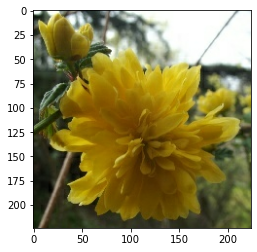

In [33]:
#testing_path = 'training_tfrecords/validation/train_0.tfrecord'
pathh = '/Users/lucianoaraujo/Desktop/LifeCLEFPlant2015/PLANTCLEF2015/tfrecords/sandbox/train_499.tfrecord'
dataset = tf.data.TFRecordDataset(filenames=pathh)
# Parse the dataset using a parsing function 
parsed_dataset = dataset.map(parsing_fn)
# Gets a sample from the iterator
iterator = tf.compat.v1.data.make_one_shot_iterator(parsed_dataset) 
#image, label = iterator.get_next()
image, (species, genus, family) = iterator.get_next()
img_array = image.numpy()
img_array = img_array.astype(np.uint8)
plt.imshow(img_array)
#print(species.numpy())
plt.show()

In [6]:
np.argmax(species) 

497

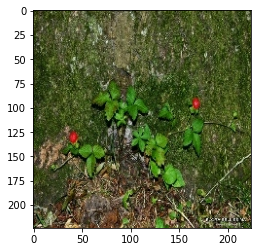

In [16]:
#testing_path = 'training_tfrecords/validation/train_0.tfrecord'
pathh = '/Users/lucianoaraujo/Desktop/LifeCLEFPlant2015/PLANTCLEF2015/tfrecords/sandbox/train_497.tfrecord'
dataset = tf.data.TFRecordDataset(filenames=pathh)
# Parse the dataset using a parsing function 
parsed_dataset = dataset.map(parsing_fn)
# Gets a sample from the iterator
iterator = tf.compat.v1.data.make_one_shot_iterator(parsed_dataset) 
#image, label = iterator.get_next()
image, (species, genus, family) = iterator.get_next()
img_array = image.numpy()
img_array = img_array.astype(np.uint8)
plt.imshow(img_array)
#print(species.numpy())
plt.show()

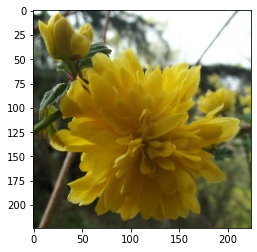

In [30]:
#testing_path = 'training_tfrecords/validation/train_0.tfrecord'
dataset = tf.data.TFRecordDataset(filenames='PLANTCLEF2015/tfrecords/train/train_6.tfrecord')
# Parse the dataset using a parsing function 
parsed_dataset = dataset.map(parsing_fn)
# Gets a sample from the iterator
iterator = tf.compat.v1.data.make_one_shot_iterator(parsed_dataset) 
#image, label = iterator.get_next()
image, (species, genus, family) = iterator.get_next()
img_array = image.numpy()
img_array = img_array.astype(np.uint8)
plt.imshow(img_array)
#print(species.numpy())
plt.show()

In [31]:
np.argmax(species)

497

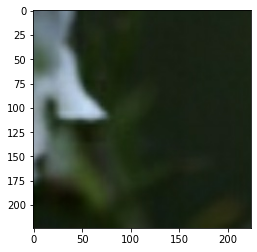

832


In [98]:
image, (species, genus, family) = iterator.get_next()
img_array = image.numpy()
img_array = img_array.astype(np.uint8)
plt.imshow(img_array)
#print(species.numpy())
plt.show()
print(np.argmax(species))

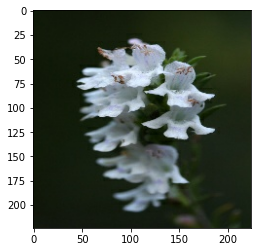

832


In [32]:
image, (species, genus, family) = iterator.get_next()
img_array = image.numpy()
img_array = img_array.astype(np.uint8)
plt.imshow(img_array)
#print(species.numpy())
plt.show()
print(np.argmax(species))

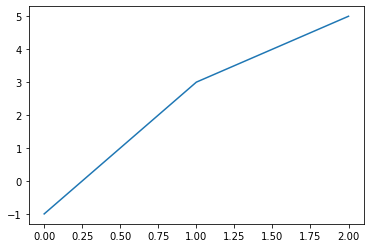

In [102]:
plt.plot([1, 2, 3])
plt.clf()
plt.plot([-1, 3, 5])

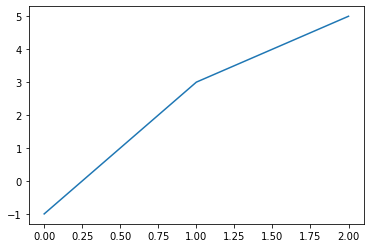

In [100]:
plt.plot([-1, 3, 5])